In [1]:
from __future__ import absolute_import, division, print_function

import argparse
import os

import warnings ; warnings.filterwarnings('ignore')
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['OMP_NUM_THREADS'] = '1'
import argparse
import collections
import os
import random
import tempfile
from argparse import RawTextHelpFormatter

import gfootball.env as football_env
import gym
import numpy as np
import ray
import ray.cloudpickle as cloudpickle
import torch
from gfootball import env as fe
from ray import tune
from ray.rllib.agents import ppo
from ray.rllib.policy.sample_batch import SampleBatch
from ray.rllib.utils.spaces.space_utils import flatten_to_single_ndarray
from ray.tune.registry import get_trainable_cls, register_env,  register_trainable
from rldm.utils import football_tools as ft
from rldm.utils import gif_tools as gt
from rldm.utils import system_tools as st
from IPython.display import HTML
from tqdm import tqdm 
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
# from gfootball.env.wrappers import CheckpointRewardWrapper

# def reward_modified(self,reward):
#     '''
#     o['active'] => 1 or 2 
#     '''
#     #change checkpoints to only 4
#     #self._num_checkpoints = 4
    
#     #assuming max of 500 steps 
#     passing_rewards = 0.002 
#     shoting_rewards = 0.1
#     not_owning_ball_team = -0.001
#     owning_ball = 0.001
#     observation = self.env.unwrapped.observation()
#     actions = self.env.unwrapped._get_actions()
#     #print(observation)
#     if observation is None:
#         return reward

#     assert len(reward) == len(observation)

#     for rew_index in range(len(reward)):
#         o = observation[rew_index]
#         a = actions[rew_index]
#         if reward[rew_index] == 1: #scoring a goal
#             reward[rew_index] += self._checkpoint_reward * (
#                 self._num_checkpoints -
#                 self._collected_checkpoints.get(rew_index, 0))
#             self._collected_checkpoints[rew_index] = self._num_checkpoints
#             #add extra points to compensate for the extra postive rewards
#             reward[rew_index] += 0.5
#             continue
        
#         #check if the right team does own the ball, this should be the first objective in the game
#         if o['ball_owned_team'] != 0:
#             #reward[rew_index] += not_owning_ball_team
#             #player need to get closer to get the ball 
#             player_pos = o['right_team'][o['active']]
#             player_ball_dist = ((o['ball'][0] - player_pos[0]) ** 2 + (o['ball'][1]-player_pos[1]) ** 2) ** 0.5
#             reward[rew_index] += player_ball_dist*not_owning_ball_team
#         else:
#             #they should positive reward for owning the ball too
#             reward[rew_index] += owning_ball
            
        
        
#         # Check if the active player has the ball.
#         if ('ball_owned_team' not in o or
#           o['ball_owned_team'] != 0 or
#           'ball_owned_player' not in o or
#           o['ball_owned_player'] != o['active']):
#             continue
#         #now, we know that the active player has the ball
#         #reward passing if the second player is closer to goal
#         #reward shooting if active player is near the goal
#         passing_thre = 0.05
#         position_second_player = o['right_team'][1 if o['active']==2 else 2]
#         dist_second_player = ((position_second_player[0] - 1) ** 2 + position_second_player[1] ** 2) ** 0.5
#         d = ((o['ball'][0] - 1) ** 2 + o['ball'][1] ** 2) ** 0.5 #ball dist to goal (the active player too)
#         player_distances = ((o['ball'][0] - position_second_player[0]) ** 2 + (o['ball'][1]-position_second_player[1]) ** 2) ** 0.5
#         #if the ball is very close, shooting would be better than passing
#         if dist_second_player + passing_thre < d and d > 0.3: 
#             if player_distances < 0.2 and a == 11: #short pass when they are near each other
#                 reward[rew_index] += passing_rewards
#             elif player_distances > 0.2 and (a == 9 or a==10):
#                 reward[rew_index] += passing_rewards
#         #now check if the ball is near target, then rewarding shotting 
#         if d < 0.4 and a ==12:
#             reward[rew_index] += shoting_rewards
            

#         # Collect the checkpoints.
#         # We give reward for distance 1 to 0.2.
#         while (self._collected_checkpoints.get(rew_index, 0) <
#              self._num_checkpoints):
#             if self._num_checkpoints == 1:
#                 threshold = 0.99 - 0.8
#             else:
#                 threshold = (0.99 - 0.8 / (self._num_checkpoints - 1) *
#                            self._collected_checkpoints.get(rew_index, 0))
#             if d > threshold:
#                 break
#             reward[rew_index] += self._checkpoint_reward
#             self._collected_checkpoints[rew_index] = (
#                 self._collected_checkpoints.get(rew_index, 0) + 1)
#     return reward

# CheckpointRewardWrapper.reward = reward_modified


In [3]:
class DefaultMapping(collections.defaultdict):
    """default_factory now takes as an argument the missing key."""

    def __missing__(self, key):
        self[key] = value = self.default_factory(key)
        return value

STAT_FUNC = {
    'min': np.min,
    'mean': np.mean,
    'median': np.median,
    'max': np.max,
    'std': np.std,
    'var': np.var,
}

In [4]:
!rm -rf /tmp/football/*

In [5]:
!ls -l /mnt/logs/baselines/**/**

-rwxrwxrwx 1 root root 2241 Jul  3 13:00 /mnt/logs/baselines/baseline_1/params.json
-rwxrwxrwx 1 root root 3090 Jul  3 13:00 /mnt/logs/baselines/baseline_1/params.pkl
-rwxrwxrwx 1 root root 2254 Jul  3 13:00 /mnt/logs/baselines/baseline_2/params.json
-rwxrwxrwx 1 root root 3095 Jul  3 13:00 /mnt/logs/baselines/baseline_2/params.pkl
-rwxrwxrwx 1 root root 2240 Jul  3 13:00 /mnt/logs/baselines/baseline_3/params.json
-rwxrwxrwx 1 root root 3090 Jul  3 13:00 /mnt/logs/baselines/baseline_3/params.pkl

/mnt/logs/baselines/baseline_1/checkpoint_0:
total 14772
-rwxrwxrwx 1 root root 15122984 Jul  3 13:00 checkpoint-0
-rwxrwxrwx 1 root root      184 Jul  3 13:00 checkpoint-0.tune_metadata

/mnt/logs/baselines/baseline_2/checkpoint_0:
total 13872
-rwxrwxrwx 1 root root 14201365 Jul  3 13:00 checkpoint-0
-rwxrwxrwx 1 root root      184 Jul  3 13:00 checkpoint-0.tune_metadata

/mnt/logs/baselines/baseline_3/checkpoint_0:
total 10928
-rwxrwxrwx 1 root root 11187733 Jul  3 13:00 checkpoint-0
-rwxrwx

In [6]:
# CHECKPOINT TO LOAD
# here are some example checkpoints from the baseline teams...
baseline1 = "/mnt/logs/baselines/baseline_1/checkpoint_0/checkpoint-0"
baseline2 = "/mnt/logs/baselines/baseline_2/checkpoint_0/checkpoint-0"
baseline3 = "/mnt/logs/baselines/baseline_3/checkpoint_0/checkpoint-0"
checkpoint_pc = "/mnt/logs/train_agents_modified_rewards_3_vs_3_auto_GK_independent_50000000_fifo_fixed/PPO_3_vs_3_auto_GK_fc470_00000_0_2022-07-15_18-07-27/checkpoint_008100/checkpoint-8100"
# checkpoint_pc = "/mnt/logs/train_agents_modified_rewards_3_vs_3_auto_GK_independent_50000000_fifo_fixed/PPO_3_vs_3_auto_GK_fc470_00000_0_2022-07-15_18-07-27/checkpoint_008951/checkpoint-8951"
# checkpoint_qmix = "/mnt/logs/
checkpoint_gcs = "/mnt/logs/my_agent/checkpoint_008900/checkpoint-8900"
checkpoints = [baseline1,baseline2,baseline3,checkpoint_gcs]
# checkpoints = [checkpoint_gcs]
num_episodes = 10
debug = False
#algorithm = "MADDPG"
algorithm = "PPO"


In [7]:
ray.init(ignore_reinit_error=True, log_to_driver=debug, include_dashboard=False,
         local_mode=True, logging_level='DEBUG' if debug else 'ERROR')

{'node_ip_address': '172.17.0.2',
 'raylet_ip_address': '172.17.0.2',
 'redis_address': '172.17.0.2:20650',
 'object_store_address': '/tmp/ray/session_2022-07-21_13-28-07_347504_15991/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-07-21_13-28-07_347504_15991/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-07-21_13-28-07_347504_15991',
 'metrics_export_port': 62328,
 'node_id': 'c91d1351215a4dbe2e21901700bb9ed64ab6079e28287f8a38da0586'}

## Matrices: Evalute all

In [11]:
def evaluate_all(agent,config,env,num_episodes=10):
    players_idx = {'player_0':1,'player_1':2 }
    policy_agent_mapping = agent.config["multiagent"]["policy_mapping_fn"]
    policy_map = agent.workers.local_worker().policy_map
    state_init = {p: m.get_initial_state() for p, m in policy_map.items()}
    use_lstm = {p: len(s) > 0 for p, s in state_init.items()}

    action_init = {
        p: flatten_to_single_ndarray(m.action_space.sample())
        for p, m in policy_map.items()
    }

    eps_stats = {}
    eps_stats['rewards_total'] = []
    eps_stats['timesteps'] = []
    eps_stats['score_reward'] = []
    eps_stats['win_perc'] = []
    eps_stats['undefeated_perc'] = []
    eps_stats["num_passes_per_eps"] = []
    eps_stats["num_shots_per_eps"] = []
    eps_stats['possession_per_eps'] = []
    eps_stats['regaining_possession_per_eps'] = []
    for eidx in tqdm(range(num_episodes)):
        mapping_cache = {}  # in case policy_agent_mapping is stochastic

        obs = env.reset()
        agent_states = DefaultMapping(
            lambda player_id: state_init[mapping_cache[player_id]])
        prev_actions = DefaultMapping(
            lambda player_id: action_init[mapping_cache[player_id]])
        prev_rewards = collections.defaultdict(lambda: 0.)

        done = False
        eps_stats['rewards_total'].append({a:0.0 for a in obs})
        eps_stats['timesteps'].append(-1)
        eps_stats['score_reward'].append(0)
        eps_stats['win_perc'].append(0)
        eps_stats['undefeated_perc'].append(0)
        possession = obs['player_0'][31]==1 #when obs[31]==1 it means the left team have the ball
        passes = 0
        shoots = 0
        regains = 0
        steps = 0 
        possession_steps= 1 if possession==True else 0
        infos = None
        while not done:
            steps +=1
            actions = {}
            for player_id, a_obs in obs.items():
                policy_id = mapping_cache.setdefault(
                    player_id, policy_agent_mapping(player_id, None))
                p_use_lstm = use_lstm[policy_id]
                if p_use_lstm:
                    a_action, p_state, _ = agent.compute_single_action(
                        a_obs,
                        state=agent_states[player_id],
                        prev_action=prev_actions[player_id],
                        prev_reward=prev_rewards[player_id],
                        policy_id=policy_id)
                    agent_states[player_id] = p_state
                else:
                    a_action = agent.compute_single_action(
                        a_obs,
                        prev_action=prev_actions[player_id],
                        prev_reward=prev_rewards[player_id],
                        policy_id=policy_id)

                a_action_flatten = flatten_to_single_ndarray(a_action)
                actions[player_id] = a_action_flatten
                prev_actions[player_id] = a_action_flatten
                
                
                if infos==None:
                    continue
                    
                infos_ = infos[player_id]['game_info']
                if (infos_['ball_owned_team'] == 0 and infos_['ball_owned_player'] == players_idx[player_id]):
#                     print(possession)
                    if a_action in [9,10,11]:
                        passes += 1
                    elif a_action == 12: #shooting
                        shoots +=1
                
            if infos!=None:
                if possession:
                    possession_steps +=1
                if not possession_pre and possession: #if i didn't have the ball, then i regain it
                    regains +=1 
            
            next_obs, rewards, dones, infos = env.step(actions)
            possession_pre = possession
            possession = next_obs['player_0'][31]==1
            done = dones['__all__']
            for player_id, r in rewards.items():
                prev_rewards[player_id] = r
                eps_stats['rewards_total'][-1][player_id] += r
            
            obs = next_obs
            eps_stats['timesteps'][-1] += 1

        eps_stats["num_passes_per_eps"].append(passes)
        eps_stats["num_shots_per_eps"].append(shoots)
        eps_stats['possession_per_eps'].append(round(possession_steps/steps,2)*100)
        eps_stats['regaining_possession_per_eps'].append(regains)
        
        eps_stats['score_reward'][-1] = infos['player_0']['score_reward']
        game_result = "loss" if infos['player_0']['score_reward'] == -1 else \
            "win" if infos['player_0']['score_reward'] == 1 else "tie"
        eps_stats['win_perc'][-1] = int(game_result == "win")
        eps_stats['undefeated_perc'][-1] = int(game_result != "loss")
        if debug:
            print(f"\nEpisode #{eidx+1} ended with a {game_result}:")
            for p, r in eps_stats['rewards_total'][-1].items():
                print("\t{} got episode reward: {:.2f}".format(p, r))
            print("\tTotal reward: {:.2f}".format(sum(eps_stats['rewards_total'][-1].values())))

    eps_stats['rewards_total'] = {k: [dic[k] for dic in eps_stats['rewards_total']] \
        for k in eps_stats['rewards_total'][0]}
    print("\n\nAll trials completed:")
    if debug:
        for stat_name, values in eps_stats.items():
            print(f"\t{stat_name}:")
            if type(values) is dict:
                for stat_name2, values2 in values.items():
                    print(f"\t\t{stat_name2}:")
                    for func_name, func in STAT_FUNC.items():
                        print("\t\t\t{}: {:.2f}".format(func_name, func(values2)))
            else:
                for func_name, func in STAT_FUNC.items():
                    print("\t\t{}: {:.2f}".format(func_name, func(values)))

    return eps_stats

In [12]:
def evaluation(eval_fuc,checkpoint, num_episodes=10, algorithm="PPO"):
    assert checkpoint, "A checkpoint string is required"

    # assert num_episodes <= 10, "Must rollout a maximum of 10 episodes--rendering takes a very long time"
    # assert num_episodes >= 1, "Must rollout at least 1 episode"

    n_cpus, _ = st.get_cpu_gpu_count()
    assert n_cpus >= 2, "Didn't find enough cpus"

    config = {}
    config_dir = os.path.dirname(checkpoint)
    config_path = os.path.join(config_dir, "../params.pkl")
    assert os.path.exists(config_path), "Could not find a proper config from checkpoint"
    with open(config_path, "rb") as f:
        config = cloudpickle.load(f)

    config["create_env_on_driver"] = True
    config["log_level"] = 'DEBUG' if debug else 'ERROR' 
    config["num_workers"] = 1
    config["num_gpus"] = 0
    test_env_name="3_vs_3_auto_GK" # this semester we're only doing 3v3 w auto GK
    
    
    register_env(test_env_name, lambda _: ft.RllibGFootball(env_name=test_env_name))
    cls = get_trainable_cls(algorithm)
    agent = cls(env=test_env_name, config=config)
    agent.restore(checkpoint)

    try:
        del env
    except:
        pass

    env = ft.RllibGFootball(env_name=config['env'], write_video=False, render=False)
    
    est_state = eval_fuc(agent,config,env,num_episodes)


    return est_state
    

In [13]:
stats = []
states_mean = {}
states_mean['wining_rate'] = []
states_mean['player_0_reward'] = []
states_mean['player_1_reward'] = []
states_mean['undefeated'] = []
states_mean['len'] = []
states_mean['score'] = []
states_mean['passes'] = []
states_mean['shooting'] = []
states_mean["possession"] = []
states_mean["interception"] = []
for i, checkpoint in enumerate(checkpoints):
    stat = evaluation(evaluate_all,checkpoint, num_episodes=1, algorithm="PPO")
    stats.append(stat)
    wining_rate = stat["win_perc"].count(1)/ len(stat["win_perc"])
    player_0_reward_mean = np.mean(stat['rewards_total']['player_0'])
    player_1_reward_mean = np.mean(stat['rewards_total']['player_1'])
    undefeated_perc = stat["undefeated_perc"].count(1)/ len(stat["undefeated_perc"])
    score_mean= np.mean(stat["score_reward"])
    len_mean = np.mean(stat["timesteps"])
    passes_mean = np.mean(stat["num_passes_per_eps"])
    shooting_mean =  np.mean(stat["num_shots_per_eps"])
    possession_mean = np.mean(stat["possession_per_eps"])
    interception_mean = np.mean(stat["regaining_possession_per_eps"])
    print("checkpint index: ",i)
    print ("wining per: ",wining_rate)
    print("player_0 average reward: ",player_0_reward_mean)
    print("player_1 average reward: ",player_1_reward_mean)
    print ("undefeated per: ",undefeated_perc)
    print ("score average: ",score_mean)
    print("epsidoe len average: ", len_mean)
    print ("passes average per eps: ",passes_mean)
    print("shooting average per eps: ",shooting_mean)
    print ("possession perc average per eps: ",possession_mean)
    print("regaining ball average per eps: ", interception_mean)
    #append data 
    states_mean['wining_rate'].append(wining_rate) 
    states_mean['player_0_reward'].append(player_0_reward_mean) 
    states_mean['player_1_reward'].append(player_1_reward_mean) 
    states_mean['undefeated'].append(undefeated_perc) 
    states_mean['len'].append(len_mean) 
    states_mean['score'].append(score_mean) 
    states_mean['passes'].append(passes_mean)
    states_mean['shooting'].append(shooting_mean)
    states_mean["possession"].append(possession_mean)
    states_mean["interception"].append(interception_mean)

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]




All trials completed:
checkpint index:  0
wining per:  1.0
player_0 average reward:  2.0
player_1 average reward:  2.0000000596046448
undefeated per:  1.0
score average:  1.0
epsidoe len average:  64.0
passes average per eps:  0.0
shooting average per eps:  3.0
possession perc average per eps:  78.0
regaining ball average per eps:  1.0


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]




All trials completed:
checkpint index:  1
wining per:  1.0
player_0 average reward:  2.0
player_1 average reward:  2.0000000596046448
undefeated per:  1.0
score average:  1.0
epsidoe len average:  75.0
passes average per eps:  0.0
shooting average per eps:  2.0
possession perc average per eps:  87.0
regaining ball average per eps:  1.0


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]




All trials completed:
checkpint index:  2
wining per:  1.0
player_0 average reward:  2.0
player_1 average reward:  2.000000014901161
undefeated per:  1.0
score average:  1.0
epsidoe len average:  140.0
passes average per eps:  0.0
shooting average per eps:  1.0
possession perc average per eps:  94.0
regaining ball average per eps:  1.0


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]



All trials completed:
checkpint index:  3
wining per:  1.0
player_0 average reward:  2.0
player_1 average reward:  2.0000000596046448
undefeated per:  1.0
score average:  1.0
epsidoe len average:  69.0
passes average per eps:  0.0
shooting average per eps:  3.0
possession perc average per eps:  86.0
regaining ball average per eps:  1.0


## Matrices: Total reward, episode len, score_reward, win_perc,undefeated_perc

In [9]:
def evaluate_wining(agent,config,env,num_episodes=10):
    policy_agent_mapping = agent.config["multiagent"]["policy_mapping_fn"]
    policy_map = agent.workers.local_worker().policy_map
    state_init = {p: m.get_initial_state() for p, m in policy_map.items()}
    use_lstm = {p: len(s) > 0 for p, s in state_init.items()}

    action_init = {
        p: flatten_to_single_ndarray(m.action_space.sample())
        for p, m in policy_map.items()
    }

    eps_stats = {}
    eps_stats['rewards_total'] = []
    eps_stats['timesteps'] = []
    eps_stats['score_reward'] = []
    eps_stats['win_perc'] = []
    eps_stats['undefeated_perc'] = []
    for eidx in tqdm(range(num_episodes)):
        mapping_cache = {}  # in case policy_agent_mapping is stochastic

        obs = env.reset()
        agent_states = DefaultMapping(
            lambda player_id: state_init[mapping_cache[player_id]])
        prev_actions = DefaultMapping(
            lambda player_id: action_init[mapping_cache[player_id]])
        prev_rewards = collections.defaultdict(lambda: 0.)

        done = False
        eps_stats['rewards_total'].append({a:0.0 for a in obs})
        eps_stats['timesteps'].append(-1)
        eps_stats['score_reward'].append(0)
        eps_stats['win_perc'].append(0)
        eps_stats['undefeated_perc'].append(0)
        while not done:
            actions = {}
            for player_id, a_obs in obs.items():
                policy_id = mapping_cache.setdefault(
                    player_id, policy_agent_mapping(player_id, None))
                p_use_lstm = use_lstm[policy_id]
                if p_use_lstm:
                    a_action, p_state, _ = agent.compute_single_action(
                        a_obs,
                        state=agent_states[player_id],
                        prev_action=prev_actions[player_id],
                        prev_reward=prev_rewards[player_id],
                        policy_id=policy_id)
                    agent_states[player_id] = p_state
                else:
                    a_action = agent.compute_single_action(
                        a_obs,
                        prev_action=prev_actions[player_id],
                        prev_reward=prev_rewards[player_id],
                        policy_id=policy_id)

                a_action = flatten_to_single_ndarray(a_action)
                actions[player_id] = a_action
                prev_actions[player_id] = a_action

            next_obs, rewards, dones, infos = env.step(actions)

            done = dones['__all__']
            for player_id, r in rewards.items():
                prev_rewards[player_id] = r
                eps_stats['rewards_total'][-1][player_id] += r

            obs = next_obs
            eps_stats['timesteps'][-1] += 1

        eps_stats['score_reward'][-1] = infos['player_0']['score_reward']
        game_result = "loss" if infos['player_0']['score_reward'] == -1 else \
            "win" if infos['player_0']['score_reward'] == 1 else "tie"
        eps_stats['win_perc'][-1] = int(game_result == "win")
        eps_stats['undefeated_perc'][-1] = int(game_result != "loss")
        if debug:
            print(f"\nEpisode #{eidx+1} ended with a {game_result}:")
            for p, r in eps_stats['rewards_total'][-1].items():
                print("\t{} got episode reward: {:.2f}".format(p, r))
            print("\tTotal reward: {:.2f}".format(sum(eps_stats['rewards_total'][-1].values())))

    eps_stats['rewards_total'] = {k: [dic[k] for dic in eps_stats['rewards_total']] \
        for k in eps_stats['rewards_total'][0]}
    print("\n\nAll trials completed:")
    if debug:
        for stat_name, values in eps_stats.items():
            print(f"\t{stat_name}:")
            if type(values) is dict:
                for stat_name2, values2 in values.items():
                    print(f"\t\t{stat_name2}:")
                    for func_name, func in STAT_FUNC.items():
                        print("\t\t\t{}: {:.2f}".format(func_name, func(values2)))
            else:
                for func_name, func in STAT_FUNC.items():
                    print("\t\t{}: {:.2f}".format(func_name, func(values)))

    return eps_stats

In [18]:
stats_1 = []
states_mean = {}
states_mean['wining_rate'] = []
states_mean['player_0_reward'] = []
states_mean['player_1_reward'] = []
states_mean['undefeated'] = []
states_mean['len'] = []
states_mean['score'] = []
for i, checkpoint in enumerate(checkpoints):
    stat = evaluation(evaluate_wining,checkpoint, num_episodes=100, algorithm="PPO")
    stats_1.append(stat)
    wining_rate = stat["win_perc"].count(1)/ len(stat["win_perc"])
    player_0_reward_mean = np.mean(stat['rewards_total']['player_0'])
    player_1_reward_mean = np.mean(stat['rewards_total']['player_1'])
    undefeated_perc = stat["undefeated_perc"].count(1)/ len(stat["undefeated_perc"])
    score_mean= np.mean(stat["score_reward"])
    len_mean = np.mean(stat["timesteps"])
    print("checkpint index: ",i)
    print ("wining per: ",wining_rate)
    print("player_0 average reward: ",player_0_reward_mean)
    print("player_1 average reward: ",player_1_reward_mean)
    print ("undefeated per: ",undefeated_perc)
    print ("score average: ",score_mean)
    print("epsidoe len average: ", len_mean)
    #append data 
    states_mean['wining_rate'].append(wining_rate) 
    states_mean['player_0_reward'].append(player_0_reward_mean) 
    states_mean['player_1_reward'].append(player_1_reward_mean) 
    states_mean['undefeated'].append(undefeated_perc) 
    states_mean['len'].append(len_mean) 
    states_mean['score'].append(score_mean) 
    


100%|█████████████████████████████████████████| 100/100 [04:11<00:00,  2.52s/it]




All trials completed:
checkpint index:  0
wining per:  0.3
player_0 average reward:  0.5510000005364418
player_1 average reward:  0.6999999958276749
undefeated per:  0.94
score average:  0.24
epsidoe len average:  98.42


100%|█████████████████████████████████████████| 100/100 [05:42<00:00,  3.43s/it]




All trials completed:
checkpint index:  1
wining per:  0.41
player_0 average reward:  0.75
player_1 average reward:  0.8270000253617763
undefeated per:  0.93
score average:  0.34
epsidoe len average:  122.47


100%|█████████████████████████████████████████| 100/100 [07:05<00:00,  4.25s/it]




All trials completed:
checkpint index:  2
wining per:  0.44
player_0 average reward:  0.8130000001192093
player_1 average reward:  0.8580000083893538
undefeated per:  0.93
score average:  0.37
epsidoe len average:  139.79


100%|█████████████████████████████████████████| 100/100 [04:47<00:00,  2.87s/it]



All trials completed:
checkpint index:  3
wining per:  0.41
player_0 average reward:  0.8
player_1 average reward:  0.8770000240206719
undefeated per:  0.98
score average:  0.39
epsidoe len average:  71.62


In [19]:
for key in states_mean.keys():
    data = {'Checkpoint': ['baseline_1','baseline_2','baseline_3','MR_PPO'], key:states_mean[key]}
    New_Colors = ['green','blue','purple','brown']
    
    df = pd.DataFrame(data)
    sns.barplot(x='Checkpoint', y=key, capsize=0.2, data=df).set(title="Avarage {} for each Checkpoint".format(key))
    plt.xticks(rotation=40)
    plt.tight_layout()
    plt.savefig('{}.png'.format(key))
    plt.clf()

Figure(432x288)


## num of passing

In [20]:
def evaluate_actions(agent,config,env,num_episodes=10):
    players_idx = {'player_0':1,'player_1':2 }
    policy_agent_mapping = agent.config["multiagent"]["policy_mapping_fn"]
    policy_map = agent.workers.local_worker().policy_map
    state_init = {p: m.get_initial_state() for p, m in policy_map.items()}
    use_lstm = {p: len(s) > 0 for p, s in state_init.items()}

    action_init = {
        p: flatten_to_single_ndarray(m.action_space.sample())
        for p, m in policy_map.items()
    }
    eps_stats = {}
    eps_stats["num_passes_per_eps"] = []
    eps_stats["num_shots_per_eps"] = []
    for eidx in tqdm(range(num_episodes)):
        mapping_cache = {}  # in case policy_agent_mapping is stochastic

        obs = env.reset()
        agent_states = DefaultMapping(
            lambda player_id: state_init[mapping_cache[player_id]])
        prev_actions = DefaultMapping(
            lambda player_id: action_init[mapping_cache[player_id]])
        prev_rewards = collections.defaultdict(lambda: 0.)
        passes = 0
        shoots = 0
        done = False
        while not done:
            actions = {}
            for player_id, a_obs in obs.items():
                policy_id = mapping_cache.setdefault(
                    player_id, policy_agent_mapping(player_id, None))
                p_use_lstm = use_lstm[policy_id]
                if p_use_lstm:
                    a_action, p_state, _ = agent.compute_single_action(
                        a_obs,
                        state=agent_states[player_id],
                        prev_action=prev_actions[player_id],
                        prev_reward=prev_rewards[player_id],
                        policy_id=policy_id)
                    agent_states[player_id] = p_state
                else:
                    a_action = agent.compute_single_action(
                        a_obs,
                        prev_action=prev_actions[player_id],
                        prev_reward=prev_rewards[player_id],
                        policy_id=policy_id)


                a_action_flatten = flatten_to_single_ndarray(a_action)
                actions[player_id] = a_action_flatten
                prev_actions[player_id] = a_action_flatten

            next_obs, rewards, dones, infos = env.step(actions)
            infos = infos[player_id]['game_info']
    #         print(infos['ball_owned_player'])
            if (infos['ball_owned_team'] == 0 and infos['ball_owned_player'] == players_idx[player_id]): 
                if a_action in [9,10,11]:
                    passes += 1
                elif a_action == 12: #shooting
                    shoots +=1

            done = dones['__all__']
            for player_id, r in rewards.items():
                prev_rewards[player_id] = r

            obs = next_obs
        eps_stats["num_passes_per_eps"].append(passes)
        eps_stats["num_shots_per_eps"].append(shoots)
    
    return eps_stats

    



In [21]:
stats_2 = []

states_mean_2 = {}
states_mean_2['passes'] = []
states_mean_2['shooting'] = []
for i, checkpoint in enumerate(checkpoints):
    stat = evaluation(evaluate_actions,checkpoint, num_episodes=100, algorithm="PPO")
    passes_mean = np.mean(stat["num_passes_per_eps"])
    shooting_mean =  np.mean(stat["num_shots_per_eps"])
    print ("passes average per eps: ",passes_mean)
    print("shooting average per eps: ",shooting_mean)
    
    states_mean_2['passes'].append(passes_mean)
    states_mean_2['shooting'].append(shooting_mean)

100%|█████████████████████████████████████████| 100/100 [11:11<00:00,  6.72s/it]


passes average per eps:  0.13
shooting average per eps:  1.39


100%|█████████████████████████████████████████| 100/100 [11:28<00:00,  6.88s/it]


passes average per eps:  0.0
shooting average per eps:  1.34


100%|█████████████████████████████████████████| 100/100 [17:07<00:00, 10.27s/it]


passes average per eps:  0.01
shooting average per eps:  0.86


100%|█████████████████████████████████████████| 100/100 [16:14<00:00,  9.75s/it]

passes average per eps:  0.01
shooting average per eps:  1.6


In [22]:
for key in states_mean_2.keys():
    data = {'Checkpoint': ['baseline_1','baseline_2','baseline_3','MR_PPO'], key:states_mean_2[key]}
    New_Colors = ['green','blue','purple','brown']
    
    df = pd.DataFrame(data)
    sns.barplot(x='Checkpoint', y=key, capsize=0.2, data=df).set(title="Avarage {}  for each Checkpoint".format(key))
    plt.xticks(rotation=40)
    plt.tight_layout()
    plt.savefig('{}.png'.format(key))
    plt.clf()

Figure(432x288)


## Regaining possession

In [23]:
def evalaute_possession(agent,config,env,num_episodes=10):
    players_idx = {'player_0':1,'player_1':2 }
    policy_agent_mapping = agent.config["multiagent"]["policy_mapping_fn"]
    policy_map = agent.workers.local_worker().policy_map
    state_init = {p: m.get_initial_state() for p, m in policy_map.items()}
    use_lstm = {p: len(s) > 0 for p, s in state_init.items()}

    action_init = {
        p: flatten_to_single_ndarray(m.action_space.sample())
        for p, m in policy_map.items()
    }

    eps_stats = {}
    eps_stats['possession_per_eps'] = []
    eps_stats['regaining_possession_per_eps'] = []
    for eidx in tqdm(range(num_episodes)):
        mapping_cache = {}  # in case policy_agent_mapping is stochastic
        obs = env.reset()
        agent_states = DefaultMapping(
            lambda player_id: state_init[mapping_cache[player_id]])
        prev_actions = DefaultMapping(
            lambda player_id: action_init[mapping_cache[player_id]])
        prev_rewards = collections.defaultdict(lambda: 0.)
        possession = obs['player_0'][31]==1 #when obs[31]==1 it means the left team have the ball
        regains = 0
        steps = 0 
        possession_steps= 1 if possession==True else 0
        done = False
        while not done:
            steps +=1
            actions = {}
            for player_id, a_obs in obs.items():
                policy_id = mapping_cache.setdefault(
                    player_id, policy_agent_mapping(player_id, None))
                p_use_lstm = use_lstm[policy_id]
                if p_use_lstm:
                    a_action, p_state, _ = agent.compute_single_action(
                        a_obs,
                        state=agent_states[player_id],
                        prev_action=prev_actions[player_id],
                        prev_reward=prev_rewards[player_id],
                        policy_id=policy_id)
                    agent_states[player_id] = p_state
                else:
                    a_action = agent.compute_single_action(
                        a_obs,
                        prev_action=prev_actions[player_id],
                        prev_reward=prev_rewards[player_id],
                        policy_id=policy_id)


                a_action_flatten = flatten_to_single_ndarray(a_action)
                actions[player_id] = a_action_flatten
                prev_actions[player_id] = a_action_flatten

            next_obs, rewards, dones, infos = env.step(actions)

            possession_next = next_obs['player_0'][31]==1
            if possession_next:
                possession_steps +=1
            if not possession and possession_next: #if i didn't have the ball, then i regain it
                regains +=1 
            done = dones['__all__']
            for player_id, r in rewards.items():
                prev_rewards[player_id] = r

            possession = possession_next
            obs = next_obs
        eps_stats['possession_per_eps'].append(round(possession_steps/steps,2)*100)
        eps_stats['regaining_possession_per_eps'].append(regains)

    return eps_stats

In [24]:
stats_3 = []
states_mean_3 = {}
states_mean_3["possession"] = []
states_mean_3["interception"] = []
for i, checkpoint in enumerate(checkpoints):
    stat = evaluation(evalaute_possession,checkpoint, num_episodes=100, algorithm="PPO")
    possession_mean = np.mean(stat["possession_per_eps"])
    interception_mean = np.mean(stat["regaining_possession_per_eps"])
    print ("possession perc average per eps: ",possession_mean)
    print("regaining ball average per eps: ", interception_mean)
    states_mean_3["possession"].append(possession_mean)
    states_mean_3["interception"].append(interception_mean)
    

100%|█████████████████████████████████████████| 100/100 [30:46<00:00, 18.47s/it]


possession perc average per eps:  35.83
regaining ball average per eps:  0.68


100%|█████████████████████████████████████████| 100/100 [37:08<00:00, 22.29s/it]


possession perc average per eps:  42.03
regaining ball average per eps:  0.68


100%|█████████████████████████████████████████| 100/100 [44:20<00:00, 26.61s/it]


possession perc average per eps:  41.64
regaining ball average per eps:  0.66


100%|█████████████████████████████████████████| 100/100 [43:17<00:00, 25.98s/it]


possession perc average per eps:  37.2
regaining ball average per eps:  0.59


In [25]:
for key in states_mean_3.keys():
    data = {'Checkpoint': ['baseline_1','baseline_2','baseline_3','MR_PPO'], key:states_mean_3[key]}
    New_Colors = ['green','blue','purple','brown']
    
    df = pd.DataFrame(data)
    sns.barplot(x='Checkpoint', y=key, capsize=0.2, data=df).set(title="Avarage {} % for each Checkpoint".format(key))
    plt.xticks(rotation=40)
    plt.tight_layout()
    plt.savefig('{}.png'.format(key))
    plt.clf()

Figure(432x288)


In [15]:
def smooth(scalars, weight=0.99):  # Weight between 0 and 1
    """

    ref: https://stackoverflow.com/questions/42281844/what-is-the-mathematics-behind-the-smoothing-parameter-in-tensorboards-scalar

    :param scalars:
    :param weight:
    :return:
    """
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed: list = []
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return smoothed

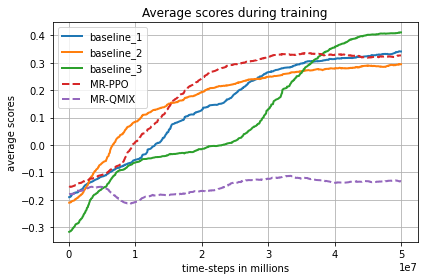

In [31]:
import pandas as pd
from matplotlib import pyplot as plt
labels = ['baseline_1','baseline_2','baseline_3',"MR-PPO","MR-QMIX"]
files_name = ['baseline_1','baseline_2','baseline_3','my_agent','my_agent_qmix']
# Set the figure size
plt.rcParams["figure.figsize"] = [6.00, 4.0]
plt.rcParams["figure.autolayout"] = True

for i, file_name in enumerate(files_name):

    # Read a CSV file
    df = pd.read_csv("training_data/{}.csv".format(file_name))
    x = df["Step"].values
    y = df["Value"].values
    y = smooth(y)
    # # Plot the lines
    if i <=2:
        plt.plot(x,y,label=labels[i],linewidth='2.0')
    else:
        plt.plot(x,y,label=labels[i],linewidth='2.0',ls="--")

plt.title("Average scores during training")
plt.xlabel('time-steps in millions')
plt.ylabel('average scores')
plt.grid()
plt.legend()
plt.savefig('average_scores_training.png')
plt.show()